# **Pantanal.dev**

### Análise de Sentimentos (Tweets)

Este projeto tem por objetivo desenvolver um modelo de análise de sentimentos utilizando tweets com o uso do modelo pré-treinado BERT. 



### Setup

Instala bibliotecas necessárias

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.9 MB/s eta 0:00:00


Importa bibliotecas necessárias

In [ ]:
import torch
import re
import transformers

import torch.nn as nn
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

from google.colab import drive
from sklearn.model_selection import train_test_split
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

Declara variáveis globais

In [ ]:
BATCH_SIZE = 4
MAX_LENGTH = 100
RANDOM_SEED = 42
NUM_CLASSES = 3
EPOCHS = 100
LEARNING_RATE = 1e-7
DROPOUT_RATE = 0.3
PRE_TRAINED_MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

empresas = ['ifood', 'shein', 'shopee', 'nestlé', 'nestle', 'tesla', 'sadia', 'natura', 'ubisoft', 'ambev', 'nubank', 'phillips', 'philips', 'fabber', 'wepink', 'apple', 'itaú', 'itau', 'havan', 'cargil', 'cacaushow', 'cacau show', 'samsung', 'tilibra']

### Inicialização

Carrega base de dados do Drive

In [ ]:
drive.mount("/content/drive")

url = "/content/drive/MyDrive/tweets_pantanal_proporcional.csv"

tweets = pd.read_csv(url)

Mounted at /content/drive


Mostra base de dados

In [ ]:
tweets

,tweet_text,sentiment
0,Fazendas fornecedoras da Coca e Nestlé usam ag...,Positivo
1,Aniversário bem docinho.\n \nObrigada. \nDenis...,Positivo
2,Alerta aos Tiligamers! Vem de caderno Playstat...,Positivo
3,Regresso ás aulas em http://Delikatessen.pt de...,Positivo
4,"Gente, #WePink é babado! Ansiosa para experime...",Positivo
...,...,...
4231,Extremamente indignado com a \n@nubank\n por u...,Negativo
4232,"#ifood quero nem saber, minha taxa em dobro vi...",Negativo
4233,#IPCA #ITAU \n\nIPCA de março segue indicando ...,Negativo
4234,como que faz pra abolir a nestle da minha vida...,Negativo


Imprime quantidade de tweets positivos, negativos e neutros

In [ ]:
tweets['sentiment'].value_counts()

Positivo    1412
Neutro      1412
Negativo    1412
Name: sentiment, dtype: int64

### Limpeza de dados

Realiza limpeza nos tweets

In [ ]:
def clean_tweet(tweet):
  # Converte tudo para minúsculo
  tweet = tweet.lower()

  # Remove menções
  tweet = re.sub(r'@[A-Za-z0-9]+', '', tweet)

  # Remove #
  tweet = re.sub(r'#', '', tweet)

  # Remove hyperlinks
  tweet = re.sub(r'https?:\/\/\S+', '', tweet)

  # Remove pontuação
  tweet = re.sub(r'[^\w\s]', '', tweet)

  # Remove \n
  tweet = re.sub(r'\n', '', tweet)

  return tweet

In [ ]:
def limpa_tweets(tweets):
  # Percorre lista de tweets e realiza a limpeza
  for i in range(len(tweets['tweet_text'])):
    tweets['tweet_text'][i] = clean_tweet(tweets['tweet_text'][i])

In [ ]:
limpa_tweets(tweets)

Converte cada classe de sentimento em um ID

2 : Positivo

1 : Neutro

0 : Negativo

In [ ]:
def formata_sentimentos(tweets):
  for i in range(len(tweets.sentiment)):
    if tweets.sentiment[i] == 'Positivo':
      tweets.sentiment[i] = 2
    elif tweets.sentiment[i] == 'Neutro':
      tweets.sentiment[i] = 1
    elif tweets.sentiment[i] == 'Negativo':
      tweets.sentiment[i] = 0

In [ ]:
formata_sentimentos(tweets)

In [ ]:
def remove_nome_empresas(tweets):
  for i in range(len(tweets['tweet_text'])):
    tweet = tweets['tweet_text'][i]

    for empresa in empresas:
      tweet = tweet.replace(empresa, '')
    
    tweets['tweet_text'][i] = tweet

In [ ]:
remove_nome_empresas(tweets)

In [ ]:
tweets

,tweet_text,sentiment
0,fazendas fornecedoras da coca e usam agrotóxi...,2
1,aniversário bem docinho obrigada denise cleide...,2
2,alerta aos tiligamers vem de caderno playstati...,2
3,regresso ás aulas em desde 1998 as melhores m...,2
4,gente é babado ansiosa para experimentar,2
...,...,...
4231,extremamente indignado com a por um péssimo s...,0
4232,quero nem saber minha taxa em dobro viu,0
4233,ipca ipca de março segue indicando perspectiv...,0
4234,como que faz pra abolir a da minha vida agora,0


Contabiliza quantidade máxima de tokens em um tweet (utilizado para definir a variável global MAX_LENGTH)

In [ ]:
token_lengths = []

for tweet in tweets.tweet_text:
  token = tokenizer.encode(tweet, truncation = True, max_length = 512)
  token_lengths.append(len(token))

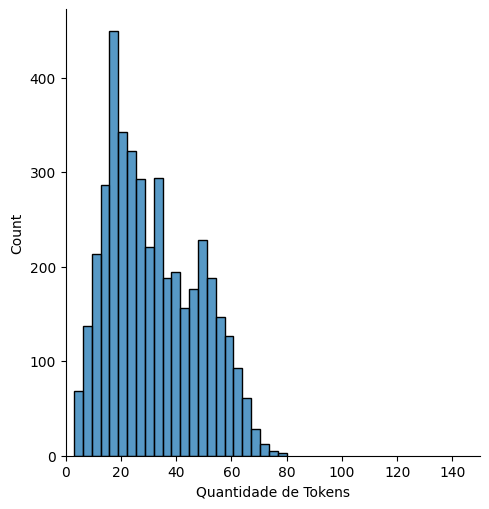

In [ ]:
sns.displot(token_lengths)

plt.xlim([0, 150]);
plt.xlabel('Quantidade de Tokens');

### Divisão de Datasets

Divide base de dados original em uma base de treino (70%), teste (20%) e validação (10%) e com quantidade proporcionais de cada sentimento

In [ ]:
dataset_train, dataset_test = train_test_split(tweets, test_size = 0.3, random_state = RANDOM_SEED, shuffle = True, stratify = tweets.sentiment)
dataset_test, dataset_val = train_test_split(dataset_test, test_size = 0.66, random_state = RANDOM_SEED, shuffle = True, stratify = dataset_test.sentiment)

In [ ]:
dataset_train

,tweet_text,sentiment
263,apenas apaixonada pelo meu novo caderno perfei...,2
1046,a amizade é uma delícia presentei com e mostr...,2
579,a podia fazer uma caixa só com bombons da pre...,2
3015,minha tv lcd hd 42 quebrou novamente estou com...,0
523,acertou quem disse,2
...,...,...
3269,queremos uma explicação pra essa trava,0
2256,carnaval de rua em todo brasil ambulantes fatu...,1
2930,olá gostaria de saber com quem entro em conta...,0
2518,oferta compre aqui perfumemasculino perfumes ...,1


Mostra quantidade de tweets de cada sentimento em cada dataset

In [ ]:
print("Train")
print(dataset_train.sentiment.value_counts())
print()
print("Val")
print(dataset_val.sentiment.value_counts())
print()
print("Test")
print(dataset_test.sentiment.value_counts())

Train
0    989
2    988
1    988
Name: sentiment, dtype: int64

Val
2    280
1    280
0    279
Name: sentiment, dtype: int64

Test
1    144
0    144
2    144
Name: sentiment, dtype: int64


### DataLoader

Cria classe TweetDataset para representar um conjunto de dados contendo tweets

In [ ]:
class TweetDataset(Dataset):
  def __init__(self, tweets, sentiments, tokenizer):
    self.tweets = tweets
    self.sentiments = sentiments
    self.tokenizer = tokenizer
    self.max_len = MAX_LENGTH

  def __getitem__(self, index):
    tweet = self.tweets[index]
    sentiment = self.sentiments[index]

    token = tokenizer(
      tweet,
      max_length = self.max_len,
      add_special_tokens = True,
      return_token_type_ids = False,
      padding = 'max_length',
      return_attention_mask = True,
      return_tensors = 'pt',
    )

    return {
        'tweet_text' : tweet,
        'input_ids': token['input_ids'].flatten(),
        'attention_mask': token['attention_mask'].flatten(),
        'sentiment': torch.tensor(sentiment, dtype=torch.long)
    }
 
  def __len__(self):
    return len(self.tweets)

Cria função responsável por retornar os *dataloader* com seus respectivos *batches*

In [ ]:
def create_dataloader(tweets, tokenizer):
  dataset = TweetDataset(
      tweets.tweet_text.to_numpy(),
      tweets.sentiment.to_numpy(),
      tokenizer
  )

  return DataLoader(
      dataset,
      batch_size = BATCH_SIZE
  )

Cria *dataloaders* de treino, validação e teste

In [ ]:
train_dataloader = create_dataloader(dataset_train, tokenizer)
test_dataloader = create_dataloader(dataset_test, tokenizer)
val_dataloader = create_dataloader(dataset_val, tokenizer)

### Modelo

Cria classe para representar o modelo

In [ ]:
class TweetClassifier(nn.Module):
  def __init__(self):
    super(TweetClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p = DROPOUT_RATE)
    self.out = nn.Linear(self.bert.config.hidden_size, NUM_CLASSES)

  def forward(self, input_ids, attention_mask):
    # Coloca entrada no modelo BERT
    _, output = self.bert(input_ids, attention_mask, return_dict = False)

    # Coloca saída do BERT na entrada da Dropout
    output = self.drop(output)

    # Retorna a saída da camada Linear usando a saída da Dropout como entrada
    return self.out(output)

Instancia a classe com o modelo a ser utilizado e define o *optimizer*, *scheduler* e função de loss a serem utilizados

In [ ]:
model = TweetClassifier()
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE)

total_steps = len(train_dataloader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps = 0,
  num_training_steps = total_steps
)

loss_function = nn.CrossEntropyLoss().to(device)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Encapsula função responsável por rodar uma epoch de treino

In [ ]:
def train_epoch(model, dataloader, loss_function, optimizer, scheduler, len_dataset):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for batch in dataloader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    sentiments = batch['sentiment'].to(device)

    outputs = model(input_ids, attention_mask)

    _, preds = torch.max(outputs, dim = 1)

    loss = loss_function(outputs, sentiments)

    correct_predictions += torch.sum(preds == sentiments)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions / len_dataset, np.mean(losses)

Encapsula função responsável por rodar uma epoch de validação

In [ ]:
def evaluation(model, dataloader, loss_function, len_dataset):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for batch in dataloader:
      input_ids = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      sentiments = batch["sentiment"].to(device)

      outputs = model(input_ids, attention_mask)

      _, preds = torch.max(outputs, dim = 1)

      loss = loss_function(outputs, sentiments)

      correct_predictions += torch.sum(preds == sentiments)
      losses.append(loss.item())

  return correct_predictions / len_dataset, np.mean(losses)

### Treino

In [ ]:
train_accuracy_list = []
train_loss_list = []

val_accuracy_list = []
val_loss_list = []

best_accuracy = 0

early_stop = False
last_val_loss = 5

for epoch in range(EPOCHS):
  print("Epoch %d/%d" % (epoch + 1, EPOCHS))
  print("-" * 54)

  train_accuracy, train_loss = train_epoch(
    model,
    train_dataloader,    
    loss_function, 
    optimizer, 
    scheduler, 
    len(dataset_train)
  )

  print("Loss (Train)     : %.8f --> Accuracy: %.8f" % (train_loss, train_accuracy))

  val_accuracy, val_loss = evaluation(
    model,
    val_dataloader,
    loss_function,
    len(dataset_val)
  )

  print("Loss (Validation): %.8f --> Accuracy: %.8f" % (val_loss, val_accuracy))
  print()

  if val_loss > last_val_loss:
    early_stop = True

  if early_stop:
    print("Early Stopping!")
    break

  last_val_loss = val_loss

  train_accuracy_list.append(train_accuracy)
  train_loss_list.append(train_loss)
  val_accuracy_list.append(val_accuracy)
  val_loss_list.append(val_loss)

  if val_accuracy > best_accuracy:
    torch.save(model.state_dict(), 'tweet_sentiment_analysis.model')
    best_accuracy = val_accuracy

Epoch 1/100
------------------------------------------------------
Loss (Train)     : 1.10348562 --> Accuracy: 0.34367624
Loss (Validation): 1.08995837 --> Accuracy: 0.38736591

Epoch 2/100
------------------------------------------------------
Loss (Train)     : 1.09802115 --> Accuracy: 0.36458686
Loss (Validation): 1.08278462 --> Accuracy: 0.42669845

Epoch 3/100
------------------------------------------------------
Loss (Train)     : 1.08630985 --> Accuracy: 0.38279933
Loss (Validation): 1.07594762 --> Accuracy: 0.44934446

Epoch 4/100
------------------------------------------------------
Loss (Train)     : 1.08485671 --> Accuracy: 0.39190558
Loss (Validation): 1.06862783 --> Accuracy: 0.50893921

Epoch 5/100
------------------------------------------------------
Loss (Train)     : 1.07260183 --> Accuracy: 0.42596966
Loss (Validation): 1.06077564 --> Accuracy: 0.53039330

Epoch 6/100
------------------------------------------------------
Loss (Train)     : 1.06794165 --> Accuracy:

### Acurácia

Avaliação da acurácia ao longo das épocas

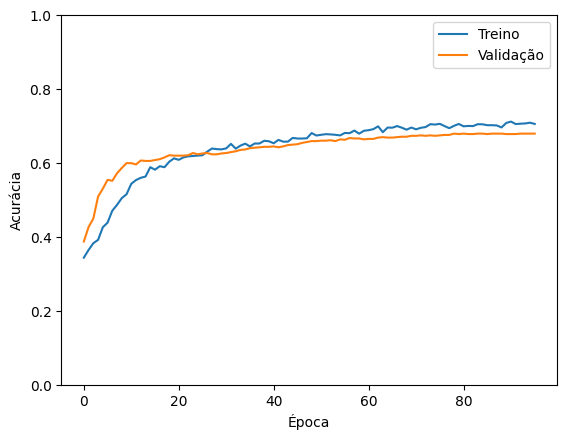

In [ ]:
train_acc_list = [acc.cpu().numpy() for acc in train_accuracy_list]
val_acc_list = [acc.cpu().numpy() for acc in val_accuracy_list]

plt.ylim([0, 1]);
plt.plot(train_acc_list, label = "Treino")
plt.plot(val_acc_list, label = "Validação")
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend()
plt.show()

### Loss

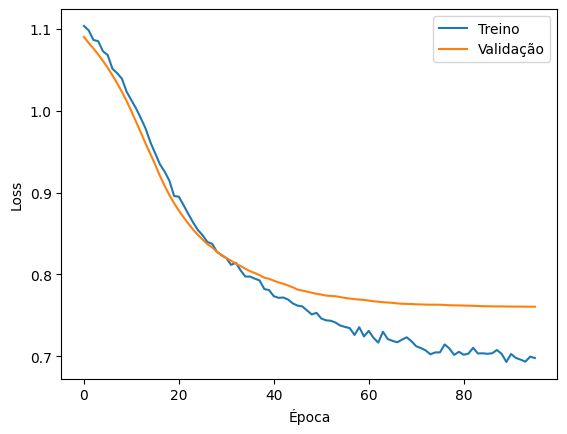

In [ ]:
plt.plot(train_loss_list, label = "Treino")
plt.plot(val_loss_list, label = "Validação")
plt.ylabel('Loss')
plt.xlabel('Época')
plt.legend()
plt.show()

### Teste

In [ ]:
tests = [
    "A Shein atrasou a entrega dos meus produtos, que decepção!", 
    "Ambev vende bebidas em mercados",     
    "Foi ótimo ganhar chocolate da Cacau Show"
]

In [ ]:
def get_tweet_sentiment(tweet):
  encoded_tweet = tokenizer(
    tweet,
    max_length = MAX_LENGTH,
    add_special_tokens = True,
    return_token_type_ids = False,
    padding = 'max_length',
    return_attention_mask = True,
    return_tensors='pt',
  )

  input_ids = encoded_tweet['input_ids'].to(device)
  attention_mask = encoded_tweet['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)

  probs = F.softmax(output, dim=1)

  print(f'Tweet: {tweet}')
  print(pd.DataFrame(probs.tolist()[0], ['negativo', 'neutro', 'positivo'])[0])
  print("========================\n")

In [ ]:
get_tweet_sentiment(tests[0])
get_tweet_sentiment(tests[1])
get_tweet_sentiment(tests[2])

Tweet: A Shein atrasou a entrega dos meus produtos, que decepção!
negativo    0.817035
neutro      0.068293
positivo    0.114672
Name: 0, dtype: float64

Tweet: Ambev vende bebidas em mercados
negativo    0.213013
neutro      0.369015
positivo    0.417972
Name: 0, dtype: float64

Tweet: Foi ótimo ganhar chocolate da Cacau Show
negativo    0.036387
neutro      0.141886
positivo    0.821727
Name: 0, dtype: float64



### Resultados

Batch size = 32

Learning rate = 1e-6

Epochs = 10

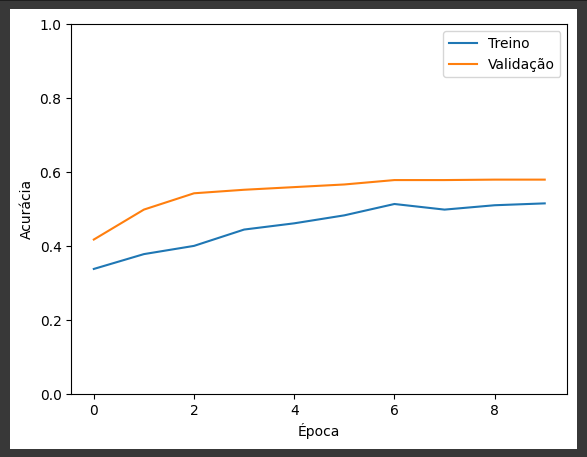

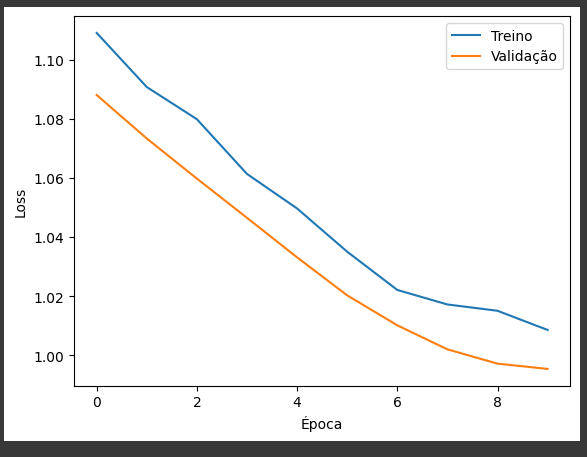

Batch size = 16

Learning rate = 1e-7

Epochs = 100

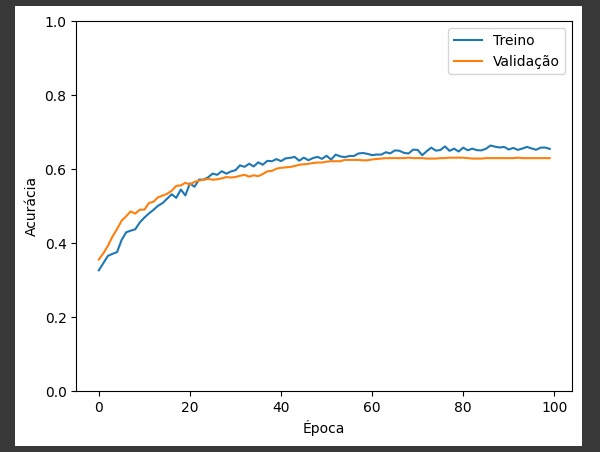

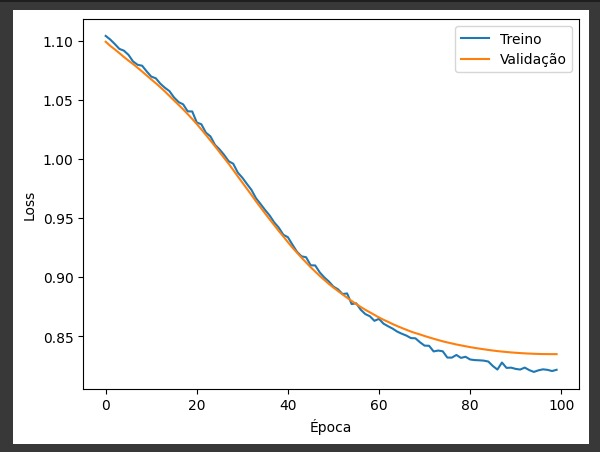

Batch size = 16

Learning rate = 3e-7

Epochs = 100

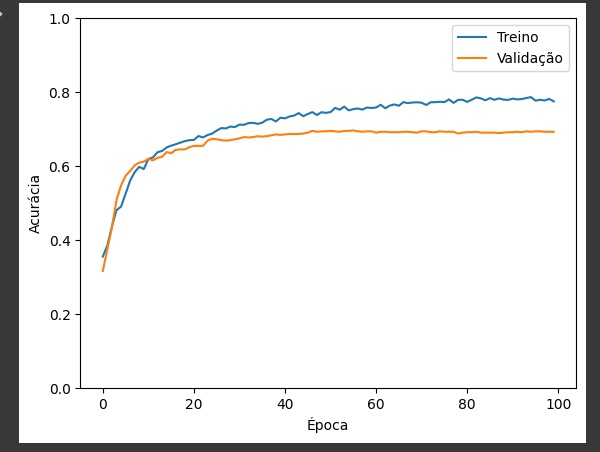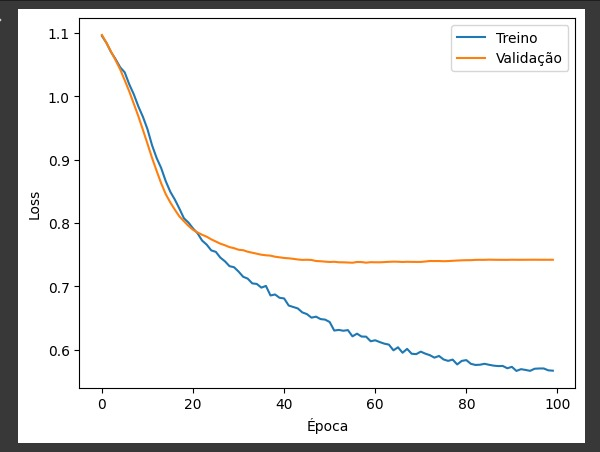

Batch size = 4

Learning rate = 3e-7

Epochs = 100

**Early Stopping (Epoch 97)**

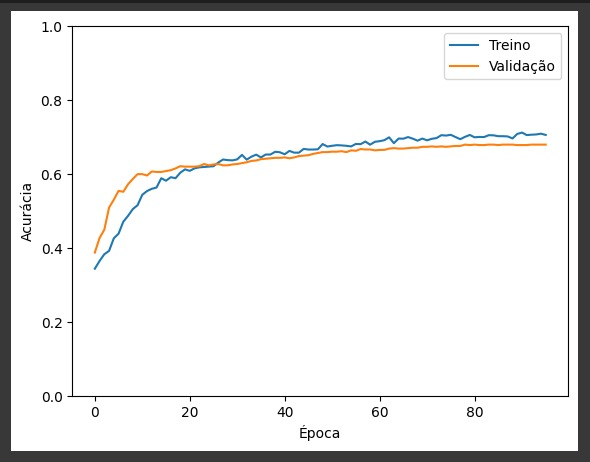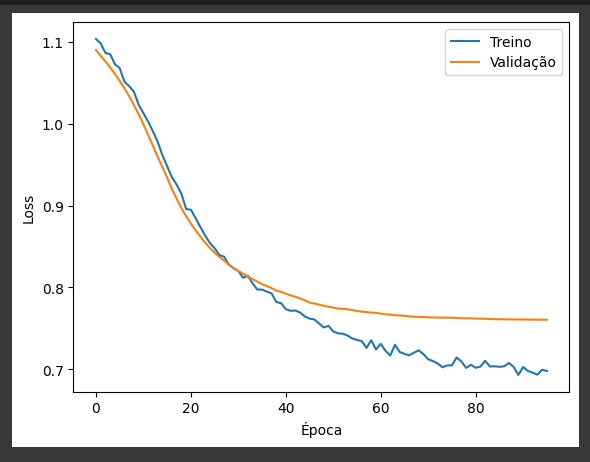